In [ ]:
# Install dependencies (run this once per environment)
!pip install diffusers transformers accelerate torch safetensors
!pip install Pillow

# Optional: Log in to Hugging Face if the model requires authentication
from huggingface_hub import login

# Uncomment and enter your Hugging Face token here if needed:
# login("YOUR_HUGGINGFACE_TOKEN")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

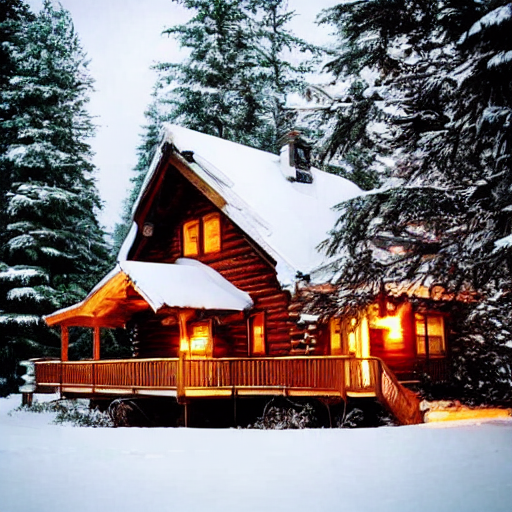

In [ ]:
# Import required libraries
from diffusers import StableDiffusionPipeline
import torch
from PIL import Image
from IPython.display import display

# Load the Stable Diffusion model
model_id = "runwayml/stable-diffusion-v1-5"

# Use float32 for CPU (float16 only works on GPU)
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float32,
)
pipe = pipe.to("cpu")  # run on CPU

# Generate an image
prompt = "a cozy cabin in the woods during snowfall"
image = pipe(prompt).images[0]

# Display the image
display(image)


In [ ]:
from IPython.display import display
import ipywidgets as widgets

prompt_box = widgets.Text(
    value='A magical forest with glowing mushrooms',
    placeholder='Type your image description...',
    description='Prompt:',
    disabled=False
)

button = widgets.Button(description="Generate Image")

output = widgets.Output()

def on_button_clicked(b):
    with output:
        output.clear_output()
        print(f"Generating image for: '{prompt_box.value}'...")
        image = pipe(prompt_box.value).images[0]
        display(image)

button.on_click(on_button_clicked)
display(prompt_box, button, output)

Text(value='A magical forest with glowing mushrooms', description='Prompt:', placeholder='Type your image desc…

Button(description='Generate Image', style=ButtonStyle())

Output()

In [ ]:
#!/usr/bin/env python3
"""
Quick diagnostic for Stable Diffusion (diffusers) problems.

- Prints Python / package versions and device info.
- Checks for a Hugging Face token in env.
- Attempts to load the pipeline and prints detailed errors and hints.

Usage:
  python debug_stable_diffusion.py
"""
import os
import sys
import traceback
import platform
import torch
import importlib

def print_header(title):
    print("\n" + "="*10 + " " + title + " " + "="*10)

def safe_import(name):
    try:
        m = importlib.import_module(name)
        print(f"{name}: OK ({getattr(m, '__version__', 'unknown')})")
    except Exception as e:
        print(f"{name}: FAILED -> {e}")

def main():
    print_header("System info")
    print("Python:", sys.version.replace("\n"," "))
    print("Platform:", platform.platform())
    print("Torch version:", getattr(torch, "__version__", "not installed"))
    print("CUDA available:", torch.cuda.is_available())
    try:
        print("Default device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    except Exception:
        pass

    print_header("Important packages")
    safe_import("diffusers")
    safe_import("transformers")
    safe_import("accelerate")
    safe_import("safetensors")
    safe_import("PIL")

    print_header("Environment variables (HUGGINGFACE_TOKEN/HF_TOKEN/HF_HOME)")
    for k in ("HUGGINGFACE_HUB_TOKEN", "HUGGINGFACE_TOKEN", "HF_TOKEN", "HF_HOME"):
        print(f"{k} = {os.environ.get(k)}")

    model_id = "runwayml/stable-diffusion-v1-5"
    print_header(f"Try loading pipeline {model_id}")

    try:
        # Import here to capture failures separately
        from diffusers import StableDiffusionPipeline
        torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
        kwargs = {}
        # If you have a Hugging Face token in env, use it automatically
        token = os.environ.get("HUGGINGFACE_HUB_TOKEN") or os.environ.get("HF_TOKEN") or os.environ.get("HUGGINGFACE_TOKEN")
        if token:
            kwargs["use_auth_token"] = token

        print("Attempting from_pretrained(...). This may download >4GB. Please be patient.")
        pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch_dtype, **kwargs)
        print("Loaded pipeline object successfully.")
        # move to device
        device = "cuda" if torch.cuda.is_available() else "cpu"
        pipe = pipe.to(device)
        # Enable attention slicing to reduce CPU memory usage
        if hasattr(pipe, "enable_attention_slicing"):
            pipe.enable_attention_slicing()
            print("Enabled attention slicing.")
        else:
            print("Pipeline has no enable_attention_slicing() method (ok).")
        print("Pipeline ready on device:", device)
        # Quick sample run with tiny settings to confirm generation path
        print("Running a tiny sample generation (1 step) to test forward pass...")
        img = pipe("test", num_inference_steps=1, guidance_scale=1.0).images[0]
        print("Sample run OK, image type:", type(img))
    except Exception as e:
        print("ERROR while loading or running pipeline:")
        traceback.print_exc()
        print("\nCommon causes & quick fixes:")
        print("- No internet or download blocked: ensure the machine has network access and huggingface.co is reachable.")
        print("- Missing HF token / model access: set HUGGINGFACE_HUB_TOKEN env var with a valid token or run `huggingface-cli login`.")
        print("- Not enough memory on CPU: try smaller image sizes, fewer steps, or use a GPU.")
        print("- Incompatible package versions: install stable versions (see below).")
        print("\nSuggested install (CPU):")
        print("  pip install --upgrade pip")
        print("  pip install 'diffusers[torch]' transformers accelerate safetensors pillow")
        print("For torch, follow official instructions at https://pytorch.org/get-started/locally/ (choose CPU or CUDA as appropriate).")
        print("\nIf you still have errors, paste the full traceback above into the chat.")

if __name__ == "__main__":
    main()


========== System info ==========
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Torch version: 2.8.0+cu126
CUDA available: False
Default device: cpu

========== Important packages ==========
diffusers: OK (0.35.2)
transformers: OK (4.57.1)
accelerate: OK (1.11.0)
safetensors: OK (0.6.2)
PIL: OK (11.3.0)

========== Environment variables (HUGGINGFACE_TOKEN/HF_TOKEN/HF_HOME) ==========
HUGGINGFACE_HUB_TOKEN = None
HUGGINGFACE_TOKEN = None
HF_TOKEN = None
HF_HOME = None

========== Try loading pipeline runwayml/stable-diffusion-v1-5 ==========
Attempting from_pretrained(...). This may download >4GB. Please be patient.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pipeline object successfully.
Enabled attention slicing.
Pipeline ready on device: cpu
Running a tiny sample generation (1 step) to test forward pass...


  0%|          | 0/1 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Sample run OK, image type: <class 'PIL.Image.Image'>


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

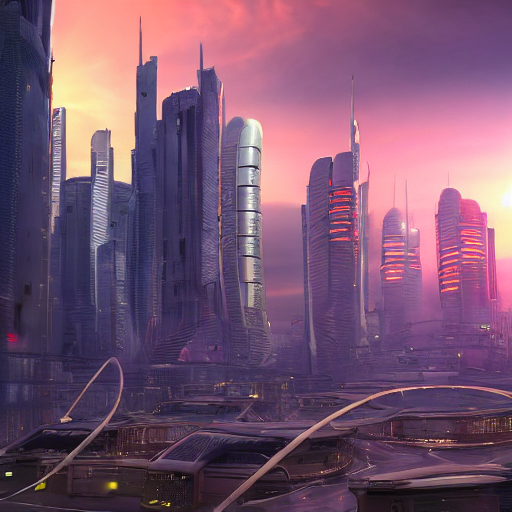

In [ ]:
# Import required libraries
from diffusers import StableDiffusionPipeline
import torch
from PIL import Image
from IPython.display import display

# Load the Stable Diffusion model
model_id = "runwayml/stable-diffusion-v1-5"

# Use float32 for CPU (float16 only works on GPU)
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float32,
)
pipe = pipe.to("cpu")  # run on CPU

# Generate an image with a new prompt
prompt = "a futuristic city at sunset"
image = pipe(prompt).images[0]

# Display the image
display(image)